## Kaggle Superheroes Competition

Team: PatataCaliente

In [1]:
# Imports
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.utils import resample
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [2]:
#pip install imblearn --user
#pip install xgboost --user

In [3]:
# Read datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
#print(train.groupby(['Race', 'Gender'])['Weight'].mean().to_string())
train['Eye color'].unique()

array([nan, 'brown', 'blue', 'green', 'black', 'white', 'amber', 'red',
       'grey', 'hazel', 'yellow (without irises)', 'yellow',
       'yellow / red', 'yellow / blue', 'purple', 'gold', 'violet',
       'bown', 'silver', 'blue / white'], dtype=object)

### Feature Engineering

In [5]:
def clean_data(df):
    """
    General feature engineering function.
    
    Args:
        df -> pandas dataframe
    """
    columns = df.columns
    for col in columns:
        if df[col].dtype == np.bool:
            df[col].fillna(False, inplace=True)
            df[col] = df[col].astype(int)
        elif df[col].dtype == np.float64:
            df[col].fillna(-99, inplace=True)
        elif df[col].dtype == np.object and col != 'Alignment':
            df[col].fillna('', inplace=True)
    
    #df = df.drop('Hair color', axis=1)
    #df = df.drop('Eye color', axis=1)
    #df = df.drop('Skin color', axis=1)

    return df

def generate_dummies(df):
    for col in df.columns:
        if df[col].dtype == np.object and col != 'Alignment':
            dummies = pd.get_dummies(df[col], prefix=col)
            df = df.join(dummies)
            df = df.drop(col, axis=1)
            
    return df

def clean_weight_height(train, test):
    cols = ['Race', 'Gender']
    #print(train.groupby(cols)['Weight'].mean())

    weight_median = train[train['Weight'] >= 0].groupby(cols).Weight.median()
    height_median = train[train['Height'] >= 0].groupby(cols).Height.median()
    
    train = sub(train, weight_median, 'Weight')
    train = sub(train, height_median, 'Height')
    test = sub(test, weight_median, 'Weight')
    test = sub(test, height_median, 'Height')
    
    #print(train.groupby(cols)['Weight'].mean())
    
    return train, test
    
def sub(df, median_groupby, col):
    cols = ['Race', 'Gender']
    df_w = df[df[col] < 0]
    df = df[df[col] >= 0]
    if col == 'Weight':
        df_w = df_w.assign(Weight=df_w.set_index(cols).index.map(median_groupby))
    else:
        df_w = df_w.assign(Height=df_w.set_index(cols).index.map(median_groupby))
    df_w[col] = df_w[col].fillna(-99)
    df = pd.concat([df, df_w])
    return df.sort_index()

def add_columns(df, columns):
    # Add non existing columns
    for col in columns:
        if col not in df.columns:
            df[col] = 0
    
    # Remove extra columns
    for col in df.columns:
        if col not in columns:
            df = df.drop(col, axis=1)
    return df

In [6]:
# Feature engineering
train_clean = clean_data(train)
test_clean = clean_data(test)

# Infer weight and height
train_clean, test_clean = clean_weight_height(train_clean, test_clean)

train_clean = generate_dummies(train_clean)
test_clean = generate_dummies(test_clean)

# Drop ID column
train_clean = train_clean.drop('Id', axis=1)
test_id = test_clean['Id']
test_clean = test_clean.drop('Id', axis=1)

In [7]:
# Remove boolean columns that are to imbalanced
"""threshold = 0.2
for col in train_clean.columns:
    if train_clean[col].dtype == np.bool:
        i, j = train_clean[col].value_counts()
        if j < (i + j) * threshold or i < (i + j) * threshold:
            train_clean.drop(col, axis=1, inplace=True)
            print('Dropped column: ', col)"""

"threshold = 0.2\nfor col in train_clean.columns:\n    if train_clean[col].dtype == np.bool:\n        i, j = train_clean[col].value_counts()\n        if j < (i + j) * threshold or i < (i + j) * threshold:\n            train_clean.drop(col, axis=1, inplace=True)\n            print('Dropped column: ', col)"

In [8]:
# Final dataframes for training
y = train_clean['Alignment']
X = train_clean.drop('Alignment', axis=1)

test_clean = add_columns(test_clean, X.columns)

# Reorder columns to have same order on train and test
train_clean = train_clean.reindex(sorted(train_clean.columns), axis=1)
test_clean = test_clean.reindex(sorted(test_clean.columns), axis=1)

# Make sure we have the same columns for train and test
assert set(train_clean.drop('Alignment', axis=1).columns) == set(test_clean.columns)

In [9]:
# Upsampling
ros = RandomOverSampler(random_state=0)
X_neutral, y_neutral = X[y == 'neutral'], y[y == 'neutral']
X_res, y_res = X[y != 'neutral'], y[y != 'neutral']

X_res, y_res = ros.fit_resample(X_res, y_res)
X = pd.concat([X_res, X_neutral]).sort_index()
y = pd.concat([y_res, y_neutral]).sort_index()
y.value_counts()

bad        262
good       262
neutral     18
Name: Alignment, dtype: int64

In [10]:
## Normalize data
scaler = preprocessing.MinMaxScaler()
X[['Weight', 'Height']] = scaler.fit_transform(X[['Weight', 'Height']])
test_clean[['Weight', 'Height']] = scaler.transform(test_clean[['Weight', 'Height']])

In [11]:
# Do the PCA decomposition!
from sklearn.decomposition import PCA

pca = PCA(tol=.95, n_components=100)
pca.fit(X)

#X = pca.transform(X) #concatenates vectors row by row
#test_clean = pca.transform(test_clean)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.95, whiten=False)

In [49]:
models = {'RFC-1': RandomForestClassifier(n_estimators=100),
          'RFC-2': RandomForestClassifier(n_estimators=200),
          'RFC-3': RandomForestClassifier(n_estimators=300),
          'DTC-3': DecisionTreeClassifier(min_samples_leaf=1, max_depth=5),
          'DTC-4': DecisionTreeClassifier(min_samples_leaf=1, max_depth=7),
          'DTC-5': DecisionTreeClassifier(min_samples_leaf=1, max_depth=9),
          'DTC-6': DecisionTreeClassifier(min_samples_leaf=1, max_depth=10),
          'DTC-7': DecisionTreeClassifier(min_samples_leaf=1, max_depth=12),
          'DTC-8': DecisionTreeClassifier(min_samples_leaf=1, max_depth=14),
          'DTC-9': DecisionTreeClassifier(min_samples_leaf=1, max_depth=16),
          'DTC-10': DecisionTreeClassifier(min_samples_leaf=1, max_depth=20)}

num_folds = 10
kf = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=0)
kf.get_n_splits()
acc = np.zeros((num_folds, len(models)))

if type(X) != type(np.zeros((10,10))):
    X = X.to_numpy()
if type(y) != type(np.zeros((10,10))):
    y = y.to_numpy()

X_t, X_test, y_t, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
for i, index in enumerate(kf.split(X_t)):
    train_index, val_index = index
    X_train, X_val = X_t[train_index], X_t[val_index]
    y_train, y_val = y_t[train_index], y_t[val_index] 

    models_list = models.values()
    fits = [model.fit(X_train, y_train) for model in models_list]
    predicts = [model.predict(X_val) for model in models_list]
    for j, prediction in enumerate(predicts):
        acc[i][j] = metrics.accuracy_score(prediction, y_val)

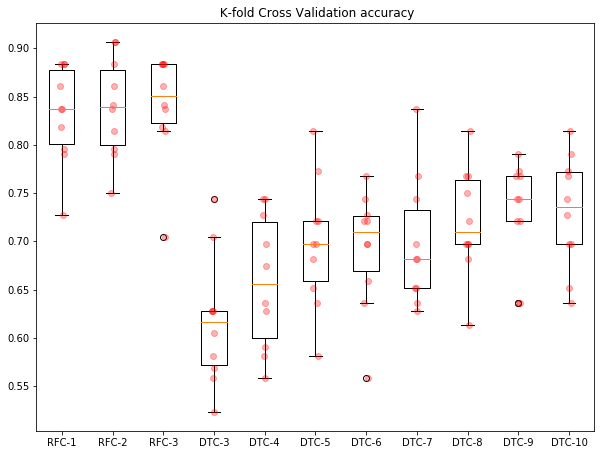

In [50]:
# Plot models performance
plt.figure(figsize=(10, 7.5))
plt.boxplot(acc)
plt.title(' K-fold Cross Validation accuracy')
for i in range(len(models)):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(models.keys())
pass

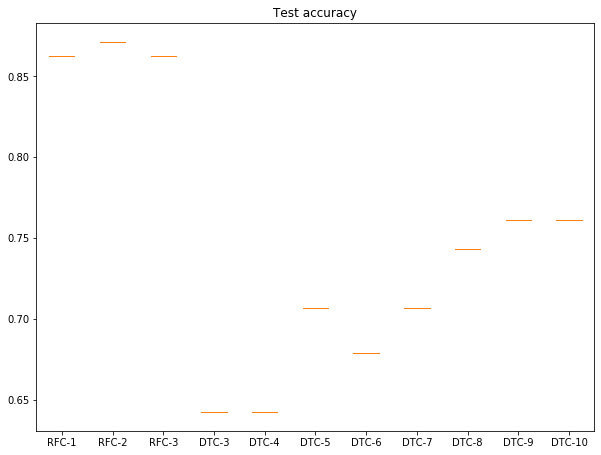

In [51]:
# Plot models performance
test_acc = np.zeros((1,len(models)))
for i, model in enumerate(models.values()):
    model.fit(X_t, y_t)
    predict = model.predict(X_test)
    test_acc[0][i] = metrics.accuracy_score(predict, y_test)

plt.figure(figsize=(10, 7.5))
plt.boxplot(test_acc)
plt.title('Test accuracy')
    
ax = plt.gca()
ax.set_xticklabels(models.keys())
pass

In [52]:
# Results on test data
model = models['DTC-8'] # Choose best model
model.fit(X, y)

predict = model.predict(test_clean)

df = pd.concat([test_id, pd.Series(predict)], axis=1)
df = df.rename({0: 'Prediction'}, axis='columns')
df.to_csv('final.csv', index=False, header=True)

good       152
bad        108
neutral      2
Name: Prediction, dtype: int64

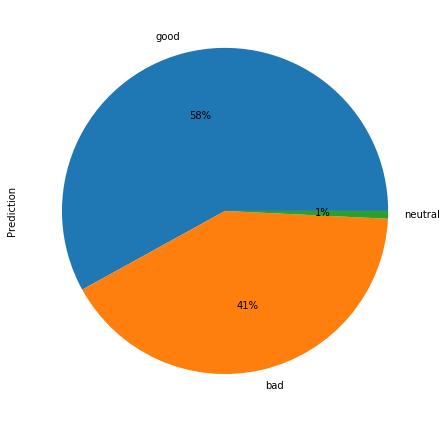

In [53]:
df.Prediction.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(7.5, 7.5))
df.Prediction.value_counts()

In [ ]:
test_clean.head()